# Algorithm Design
Design your own algorithms for the detection of green grass, water clouds, and urban-residential areas using the reflectance data of water and ice clouds, sand, grass, soil, urban-residential areas, and water within the .4 - 2.5 micrometer spectrum.

## Satellite
This will focus on using LANDSAT 8 data and bottom of atmosphere reflectance (i.e., after atmospheric correction has been applied).

### Green Grass
With "green grass", the spectral response function is heavily driven by chlorophyll's highly absorptive nature in the visible spectrum. Chlorophyll is very absorptive in the blue and red portions of the visible spectrum; however, it is reflective in the green portion of the visible spectrum. Most important for chlorophyll is the red-edge region, which is a region around .7 micrometers where the reflectance experiences a very sharp change. Therefore, any problem approaching green grass must factor in the response at ~ .8 micrometers (starting at .7 micrometers).

For green grass, the following approximate wavelengths would be great:
- .8 micrometers, sudden change in reflectance
- .4 micrometers, highly absorptive
- .55 micrometers, green: slightly reflective
- 2.2 micrometers, slightly reflective but very absorptive

The response at .4 micrometers will allow distinguishing between ice clouds and water clouds. The response at .8 will allow distinguishing water, soil, and urban-residential. The response at 2.2 will allow distinguishing sand and green grass.

### Water Clouds
Water clouds have a similar response function to ice clouds; however, they are rather distinct from the other categories in the visible spectrum. They are very reflective in the visible spectrum and parts of the near infrared. Ice clouds are also called Cirrus clouds, and they are best differentiated 

For water clouds, the following approximate wavelengths would be great:
- Anywhere from .4 to .7 micrometers, due to its' high reflectance.
- 1.4 or 1.6 micrometers.
The response in 1.6 would allow some differentiation between water and ice clouds. 

### Urban-Residential
Urban-residential is very absorptive in the visible spectrum. Similar to grass, it becomes more reflective in the near infrared, although it is not nearly as reflective. 

For urban-residential, the following approximate wavelengths would be great:
- .8 micrometers
- 1.9 micrometers

Capturing at .8 will allow differentiating between water, soil, grass, and clouds. Capturing at 1.9 micrometers will allow allow additional distinguishing between sand, soil, water, and clouds.


### Comparison Vectors
Green Grass: 
- Lawn_Grass GDS91 green DESCRIPT
- https://crustal.usgs.gov/speclab/data/HTMLmetadata/Lawn_Grass_GDS91_green_BECKa_AREF.html
- Sample also exists as resampled to Landsat 8: https://crustal.usgs.gov/speclab/data/HTMLmetadata/LawnGrass_GDS91b_+1shf-unshf_BECKa_AREF.html


In [90]:
import fiona
import geopandas as gpd
from json import load # maintaining a data.json for spectrometer and assorted information that may be repeatable
import landsatxplore as lsxp
from landsatxplore import earthexplorer as ee 
import keyring # api username/password stored in windows credential manager
import matplotlib.pyplot as plt
from math import cos, sin, pi
import numpy as np 
import os
import rasterio
from rasterio.plot import show_hist
from shapely.geometry import Polygon

# custom imports
from spectral import Spectrometer, Sample

fiona.supported_drivers['KML'] = 'rw' # yuck - remove + fiona when arcgis license comes through

In [3]:
spectral_data = open(r'../data/data.json')
spectrometers = load(spectral_data)['spectrometers']
spectrometers = [Spectrometer(**spec) for spec in spectrometers] # custom class
spectrometers[0]

'Spectrometer(spectrometer_code=BECK, wavelength_min=0.2,wavelength_max=3,bandpass_descrip=Standard setting,model_descrip=Beckman 5270)'

In [4]:
# retrieve green grass vector - need to replace with landsat 8 resampled vector later - either
# resample myself or use the resampled data
aref_file = r'../data/Lawn_Grass_GDS91/splib07a_Lawn_Grass_GDS91_green_BECKa_AREF.txt'
wavelength_file = r'..\data\Lawn_Grass_GDS91\splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt'
green_grass = Sample.from_txt_file(aref_file, wavelength_file, spectrometers) # custom class

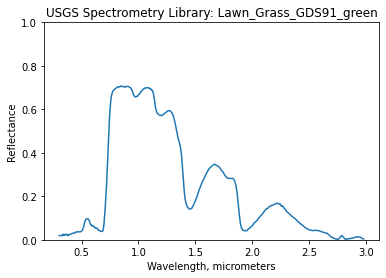

In [5]:
plt.plot(green_grass.data[0], green_grass.data[1])
plt.ylim(0,1)
plt.xlabel('Wavelength, micrometers')
plt.ylabel('Reflectance')
plt.title('USGS Spectrometry Library: Lawn_Grass_GDS91_green')
plt.show()

### Filtering green grass values to Landsat Band 3: .53 - .58

In [6]:
green_grass.spectrometer

'Spectrometer(spectrometer_code=BECK, wavelength_min=0.2,wavelength_max=3,bandpass_descrip=Standard setting,model_descrip=Beckman 5270)'

In [14]:
mask = np.logical_and(green_grass.data[0]>=.53, green_grass.data[0]<=.59)
green_grass_min = green_grass.data[1][mask].min()
green_grass_max = green_grass.data[1][mask].max()
print(f'Max: {green_grass_max:.4f} and Min: {green_grass_min:.4f}')

Max: 0.0973 and Min: 0.0668


### Filtering green grass values to Landsat Band 5: .85 - .88

In [17]:
mask = np.logical_and(green_grass.data[0]>=.85, green_grass.data[0]<=.88)
nir_grass_min = green_grass.data[1][mask].min()
nir_grass_max = green_grass.data[1][mask].max()
print(f'Max: {nir_grass_max:.4f} and Min: {nir_grass_min:.4f}')

Max: 0.7079 and Min: 0.7043


### Test Case: Greeneville, TN 
## Imagery Download then Clouds using TOA Reflectance then Grass and Surface Reflectance

In [23]:
poly = Polygon([
        [-82.84917784355127,36.16859176687424],
        [-82.76369047782862,36.16859176687424],
        [-82.76369047782862,36.22372698662217],
        [-82.84917784355127,36.22372698662217],
        [-82.84917784355127,36.16859176687424]
    ]) #can search with upper/lower bounds
center = poly.centroid 

In [24]:
uname = os.environ.get('landsat_api_username') # registered account
usgs_api = lsxp.api.API(uname, keyring.get_password('m2m.cr.usgs.gov', uname)) # literally created a generic credential and stored it in there

In [25]:
# just looking to check what landsatxplore is hitting: https://m2m.cr.usgs.gov/api/docs/json/
usgs_api.__dict__['session'].__dict__['cookies'].__dict__['_cookies']['m2m.cr.usgs.gov']['/']

{'m2m-production': Cookie(version=0, name='m2m-production', value='8oegi1orfjehno0j0gcfctnnbe', port=None, port_specified=False, domain='m2m.cr.usgs.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1698613672, discard=False, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False),
 'fwb': Cookie(version=0, name='fwb', value='3d468456d79ddb61eeddde0798bb3e65', port=None, port_specified=False, domain='m2m.cr.usgs.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1698610372, discard=False, comment=None, comment_url=None, rest={'HttpOnly': None}, rfc2109=False),
 'cookiesession1': Cookie(version=0, name='cookiesession1', value='678A3E7E85F868C04E3D8F61E944A3F6', port=None, port_specified=False, domain='m2m.cr.usgs.gov', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=False, expires=1730146072, discard=False, comment=Non

In [26]:
scenes = usgs_api.search(
    dataset='landsat_ot_c2_l2', # this is landsats OT coverage 2 level 2 - atmospherically corrected
    latitude=center.y,
    longitude=center.x,
    start_date='2015-01-01',
    end_date='2016-01-01',
    max_cloud_cover=50
)

In [27]:
gdf = gpd.GeoDataFrame.from_records(scenes)
gdf = gdf.set_geometry('spatial_coverage')
gdf = gdf.set_crs(4326)

<AxesSubplot:>

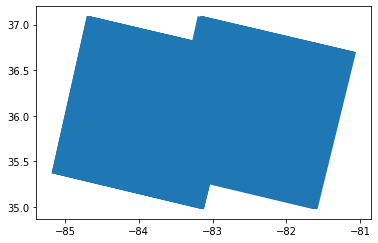

In [28]:
gdf.plot()

##### Let's only get the exteriors of the polygons so it doesn't fill and we get a better idea of activity inside the bounds

In [52]:
gdf['geometry'] = gdf['spatial_coverage'].exterior # exterior is linearring

<AxesSubplot:>

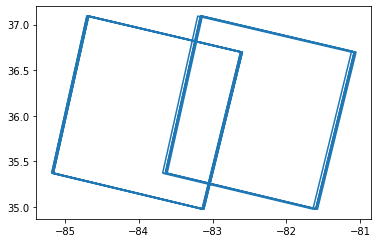

In [53]:
gdf['geometry'].plot()

### quickly save as KML to look at the coverages in google earth

In [19]:
gdf[['spatial_coverage', 'cloud_cover', 'entity_id', 'display_id', 'ordering_id', 'landsat_product_id']].to_file('coverages.kml', driver='KML')

Honestly any of these images would work -> let's just do `LC08_L1TP_018035_20150923_20200908_02_T1` because it has some cloud cover as well.

In [26]:
image = 'LC08_L1TP_018035_20150923_20200908_02_T1'
gdf[gdf['landsat_product_id']==image].iloc[0] # preview the image

cloud_cover                                                                     34
entity_id                                                    LC80180352015266LGN01
display_id                                LC08_L2SP_018035_20150923_20200908_02_T1
ordering_id                                                                   None
landsat_product_id                        LC08_L1TP_018035_20150923_20200908_02_T1
landsat_scene_id                                             LC80180352015266LGN01
acquisition_date                                               2015-09-23 00:00:00
collection_category                                            2023-10-01 00:00:00
collection_number                                                                2
wrs_path                                                                        18
wrs_row                                                                         35
target_wrs_path                                                                 18
targ

### Download the image into data folder

In [39]:
engine = ee.EarthExplorer(uname, keyring.get_password('m2m.cr.usgs.gov', uname))

In [43]:
engine.download('LC80180352015266LGN01', output_dir='../data')

Download failed with dataset id 1 of 2. Re-trying with the next one.


1.20GB [01:47, 12.0MB/s]                            


'../data\\LC08_L1TP_018035_20150923_20200908_02_T1.tar'

### Load in the MTL file so we can access projection info, image info, rescaling factors, etc

In [32]:
mtl = load(open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_MTL.json'))['LANDSAT_METADATA_FILE']

## Calculate the TOA Reflectance
To convert DNs ($Q_{cal}$) to TOA Reflectance without correction for solar angle ($\rho_{\lambda}\prime$), the formula is $\rho_{\lambda}\prime = M_{\rho}Q_{cal} + A_{\rho}$. Similar to the above, $M_\rho$ is the multiplicative factor and $A_{\rho}$ is the additive factor. To calculate TOA planetary reflectance ($\rho_{\lambda}$) it is required to divide ($\rho_{\lambda}\prime$) by either $cos(\theta_{SZ})$ or $sin(\theta_{SE})$. $\theta_{SE}$ is the local sun elevation angle, and $\theta_{SZ}$ is the solar zenith angle.

In [63]:
green = rasterio.open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_B3.TIF')
green_profile = green.profile
green_profile['dtype'] = np.float64
solar_correction = sin(float(mtl['IMAGE_ATTRIBUTES']['SUN_ELEVATION']) * pi/180)
mp = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_MULT_BAND_3'])
ap = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_ADD_BAND_3'])
green_band = green.read(1)
green_reflectance = mp*green_band + ap
green_reflectance /= solar_correction

### Preview the Image Histogram for TOA Reflectance

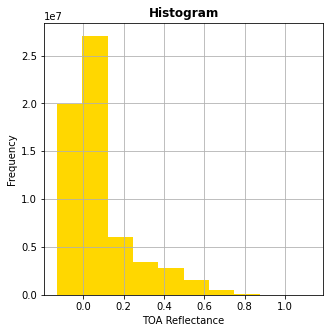

In [64]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(green_reflectance, ax=axhist)
axhist.get_legend().remove()
plt.xlabel('TOA Reflectance')
plt.show()

### Let's find our clouds in this now using a very simple technique to double check some logic
Landsat 8's Band 3 collects from .53 - .59 microns. It is unclear what our exact values should be for TOA reflectance to identify clouds; however, .55 seems to work well.

In [65]:
green_cloud_min = .55
cloud_mask = green_reflectance>=green_cloud_min
not_cloud_mask = green_reflectance<green_cloud_min

In [66]:
green_reflectance[cloud_mask] = 1
green_reflectance[not_cloud_mask] = 0

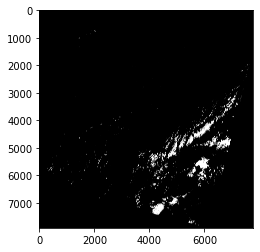

In [67]:
plt.imshow(green_reflectance, cmap='gray')
plt.show()

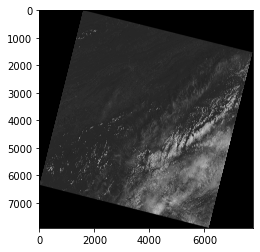

In [68]:
plt.imshow(green_band, cmap='gray')
plt.show()

In [69]:
with rasterio.open('../data/results/green_cloud_band3_calc.tif', 'w', **green_profile) as f:
    f.write(green_reflectance, 1)

### Do the same as above but using NIR band

In [80]:
nir = rasterio.open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_B5.TIF')
nir_profile = nir.profile
nir_profile['dtype'] = np.float64
sun_correction = sin(float(mtl['IMAGE_ATTRIBUTES']['SUN_ELEVATION']) * pi/180)
mp = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_MULT_BAND_5'])
ap = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['REFLECTANCE_ADD_BAND_5'])
nir_band = nir.read(1)
nir_reflectance = mp*nir_band + ap
nir_reflectance /= sun_correction

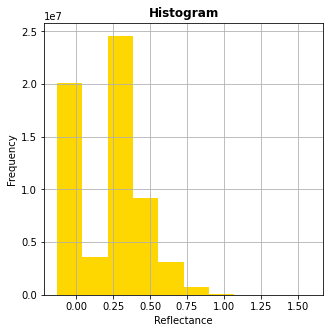

In [81]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(nir_reflectance, ax=axhist)
axhist.get_legend().remove()
plt.xlabel('Reflectance')
plt.show()

In [82]:
nir_cloud_min = .7
nir_cloud_max = 5
print(f'Max: {nir_cloud_max:.4f} and Min: {nir_cloud_min:.4f}')

Max: 5.0000 and Min: 0.7000


In [83]:
cloud_mask = np.logical_and((nir_reflectance>=nir_cloud_min),(nir_reflectance<=nir_cloud_max))
not_cloud_mask = np.logical_or((nir_reflectance<nir_cloud_min),(nir_reflectance>nir_cloud_max))
nir_reflectance[cloud_mask] = 1
nir_reflectance[not_cloud_mask] = 0

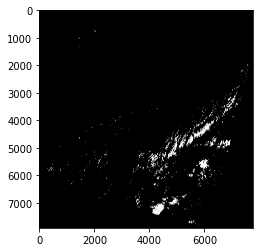

In [84]:
plt.imshow(nir_reflectance, cmap='gray')
plt.show()

In [86]:
with rasterio.open('../data/results/green_cloud_band5.tif', 'w', **nir_profile) as f:
    f.write(nir_reflectance, 1)

### Let's combine the two bands and create a combined "is it cloud" logic?

In [87]:
combined = np.stack([green_reflectance, nir_reflectance], axis=1)
cloud_mask = np.logical_and((combined[:,0,:]==1),(combined[:,1,:]==1))
clouds = np.zeros(nir_reflectance.shape)
clouds[cloud_mask] = 1

In [88]:
with rasterio.open('../data/results/clouds_band3_5.tif', 'w', **nir_profile) as f:
    f.write(clouds, 1)

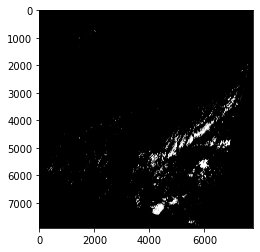

In [89]:
plt.imshow(clouds, cmap='gray')
plt.show()

### However, we can also use the brightness temperature to identify clouds.
For landsat 8 (and 9), there are two thermal bands from the TIR sensor. The scaling factors are also available in the mtl file. This is just the inverse Planck function from HW1 (?).

The resolution for TIRS is 100m, whereas the other spectral bands are 30 meters.

### Start with Band 10, Calculate the TOA Radiance First

In [101]:
thermal = rasterio.open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_B10.TIF')
thermal_profile = thermal.profile
thermal_profile['dtype'] = np.float64
ml = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['RADIANCE_MULT_BAND_10'])
al = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['RADIANCE_ADD_BAND_10'])
thermal_band = thermal.read(1)
thermal_radiance = ml*thermal_band + al

### Using the TOA Radiance, Calculate the Brightness Temperature

In [102]:
k1 = float(mtl['LEVEL1_THERMAL_CONSTANTS']['K1_CONSTANT_BAND_10'])
k2 = float(mtl['LEVEL1_THERMAL_CONSTANTS']['K2_CONSTANT_BAND_10'])
thermal_temp = k2/np.log((k1/thermal_radiance) +1) 

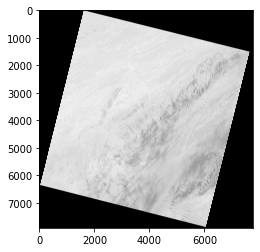

In [103]:
plt.imshow(thermal_temp, cmap='gray')
plt.show()

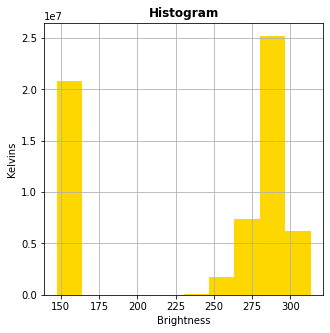

In [104]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(thermal_temp, ax=axhist)
axhist.get_legend().remove()
plt.xlabel('Brightness')
plt.ylabel('Kelvins')
plt.show()

### Band 11 Now

In [105]:
thermal11 = rasterio.open(r'../data/landsat/LC08_L1TP_018035_20150923_20200908_02_T1_B11.TIF')
thermal11_profile = thermal11.profile
thermal11_profile['dtype'] = np.float64
ml = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['RADIANCE_MULT_BAND_11'])
al = float(mtl['LEVEL1_RADIOMETRIC_RESCALING']['RADIANCE_ADD_BAND_11'])
thermal11_band = thermal11.read(1)
thermal11_radiance = ml*thermal11_band + al

In [106]:
k1 = float(mtl['LEVEL1_THERMAL_CONSTANTS']['K1_CONSTANT_BAND_11'])
k2 = float(mtl['LEVEL1_THERMAL_CONSTANTS']['K2_CONSTANT_BAND_11'])
thermal11_temp = k2/np.log((k1/thermal11_radiance) +1) 

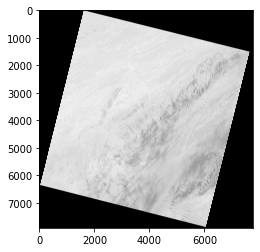

In [107]:
plt.imshow(thermal_temp, cmap='gray')
plt.show()

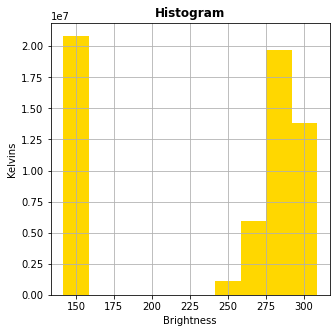

In [110]:
fig, axhist = plt.subplots(1, 1, figsize=(5, 5))
show_hist(thermal11_temp, ax=axhist)
axhist.get_legend().remove()
plt.xlabel('Brightness')
plt.ylabel('Kelvins')
plt.show()

### Subtract the two brightness calculated bands

In [115]:
thermaldiff = thermal_temp - thermal11_temp

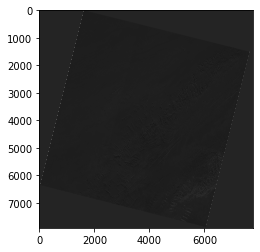

In [116]:
plt.imshow(thermaldiff, cmap='gray')
plt.show()

### Radiance instead?
MODIS uses radiance instead of TOA Brightness, and the ISCCP algorithm uses .6 and 11 micrometers (also radiance). It compares to a clear sky day though, so it requires another image that's been vetted for the location. 
There's a separate algo that uses 0.58-0.68 μm, 0.72-1.10, 5 μm, 3.55-3.93 μm, 10.3-11.3 μm, and 11.5-12.5 μm.
A pixel is called cloudy if it is brighter or colder than a threshold, if the reflectance ratio of channels
2 to 1 is between 0.7 and 1.1, if the temperature difference between channels 4 and 5 is
above a certain threshold, and if the spatial uniformity over ocean is greater than a threshold
(Kriebel and Saunders 1988).

### Resample Landat 8's Band 10 brightness temperature to the same resolution as band 5 to allow comparisons.
Clouds are "generally characterized by higher reflectance and lower temperature than the underlying earth surface".

It's probably best to use rasterio, so any spatial coordinate transformations are not affected. This also allows saving the profile with the affine transformation in it for later loading into GIS software.

#### Test using a per-pixel Solar Zenith Angle correction instead

This will also create more accurate surface reflectance files

### Calculate the Surface Reflectance - atmospheric correction
I need to do this for bands 3 & 5 at a minimum to identify grass and urban residential. The atmospheric correction constants may not be easily available (?). So, I may have to download the level 2 product already corrected instead or use 6sv or https://opg.optica.org/oe/fulltext.cfm?uri=oe-27-20-A1400&id=418704 

https://www.usgs.gov/media/files/landsat-8-collection-1-land-surface-reflectance-code-product-guide
